<center>

[![EcoCommons GDM Workflow](attachment:3eb9a10e-f24b-49a1-a356-645195f2a11b.jpg)](https://www.ecocommons.org.au/)
    
</center>

# Migratory Modelling workflow



---
Author details:  EcoCommons Platform   
Contact details: comms@ecocommons.org.au  
Copyright statement: This script is the product of the EcoCommons platform.   
                     Please refer to the EcoCommons website for more details:   
                     <https://www.ecocommons.org.au/>  
Date: September 2023  

---

#### Script and data info: 

In this Notebook example we have created a lite version of our popular marine migration use case. We will calculate occurance for only yellow tail king fish with two months January and July monthly predictions. 

For simplicity, here we use a subset of the occurrence data used in the marine use case in the EcoCommons website for the [Yellowtail Kingfish](https://www.ecocommons.org.au/marine-use-case/).We focus on occurrence data from 2012 and 2013 and maintain the seasonal trend by focusing only on one month in Summer and another in Winter (January and July, respectively)

In the near future, this material may form part of comprehensive support materials available to EcoCommons users. If you have any corrections or suggestions, please [contact the EcoCommons](mailto:comms@ecocommons.org.au) support and communications team.



## Data Preparation

You can download records directly from the Atlas of Living Australia and this includes IMOS records. 
Keep in mind with stochastic learning algorithms like Maxent, results may vary some what from run to run, even if using the same data.

Again, we recommend downloading directly from a large database each time you start a new model, but here we got some additional records from AODN which are not in the ALA data, so use the data in this folder to replicate our results. Note our ALA download includes WA near-coastal records, and does not include SA near-coastal data which were in the cleaned IMOS AODN data.

There are a few steps you need to take to download records from ALA. You need to register with ALA you can register here: https://auth.ala.org.au/userdetails/registration/createAccount.

- Data preparation for bathemetry with it's sensor locations, Bias, IMOS_array.
- Environmental variables included the marine example:
    - Chl Chlorophyll – A (chl)
    - Gridded Sea Level Anomaly (gsla)
    - Sea Surface Temperature (sst)
    - And north – south current velocity (vcur)

- Averaging the colection for the monthly (January & July)
- Modelling- extraction of monthly subsets from the environmnetal variables and running with MaxEnt


You may need to reset your local directory, and keep in mind directories are treated differently in R, Rmarkdown, and Jupyter



In [ ]:
## Loading directory and setting environment

knitr::opts_chunk$set(echo = TRUE)

getwd()

# setwd("/home/jovyan/migratory-modeling-notebooks/Example_Workflows_raw_data") # set this to your local directory # nolint: line_length_linter.

Sys.setenv(PROJ_LIB=("/opt/conda/share/proj")) #For Coding cloud only

[1] "/home/jovyan/migratory-modeling-notebooks"

In [ ]:
# De-authenticate to access public files
drive_deauth()

# Google Drive file IDs
csv_file_id <- "1mNBJAwhCiJzliAqAPWqBJf6qQ6KP11jH"
grd_file_id <- "1IDrfCzAyf3C3QYs6EhTCU8gsaIsmVbWV"
tif_file_id <- "1ChbZpogg4HgSRlalYEnhKObz0p7hSmaD"

# Download the CSV and spatial files  to the 'raw_data' directory
drive_download(as_id(csv_file_id), path = file.path(Workspace, "raw_data", "tree_kangaroo.csv"), overwrite = TRUE)
drive_download(as_id(grd_file_id), path = file.path(Workspace, "raw_data", "current.grd"), overwrite = TRUE)
drive_download(as_id(tif_file_id), path = file.path(Workspace, "raw_data", "windspath.tif"), overwrite = TRUE)

# Confirm the files have been downloaded
list.files(file.path(Workspace, "raw_data"))

In [ ]:
## Loading Packages

library("terra")
library("dplyr")
library("purrr")
library("raster") 


Here we provide the dataset needed to run the code.

You can download records directly from the Atlas of Living Australia and this
includes IMOS records. 
Keep in mind with stochastic learning algorithms like Maxent, results may vary somewhat from run to run, even if using the same data.

Again, we recommend downloading directly from a large database each time you start a new model, but here we got some additional records from AODN which are not in the ALA data, so use the data in this folder to replicate our results. Note our ALA download includes WA near-coastal records, and does not include SA near-coastal data which were in the cleaned IMOS AODN data.

There are a few steps you need to take to download records from ALA
First, you need to register with ALA you can register here: https://auth.ala.org.au/userdetails/registration/createAccount.


[1] 4446    8

[1] 924   8

 class       : SpatVector 
 geometry    : points 
 dimensions  : 924, 6  (geometries, attributes)
 extent      : 151.1303, 153.3986, -34.1378, -29.9286  (xmin, xmax, ymin, ymax)
 coord. ref. :  
 names       :   vernacularName         species coordinateUncertaintyInMeters
 type        :            <chr>           <chr>                         <num>
 values      : Yellowtail King~ Seriola lalandi                            15
               Yellowtail King~ Seriola lalandi                            31
               Yellowtail King~ Seriola lalandi                           100
  year month     basisOfRecord
 <int> <int>             <chr>
  2012     1 HUMAN_OBSERVATION
  2012     7 HUMAN_OBSERVATION
  2012     7  MACHINE_OBSERVA~

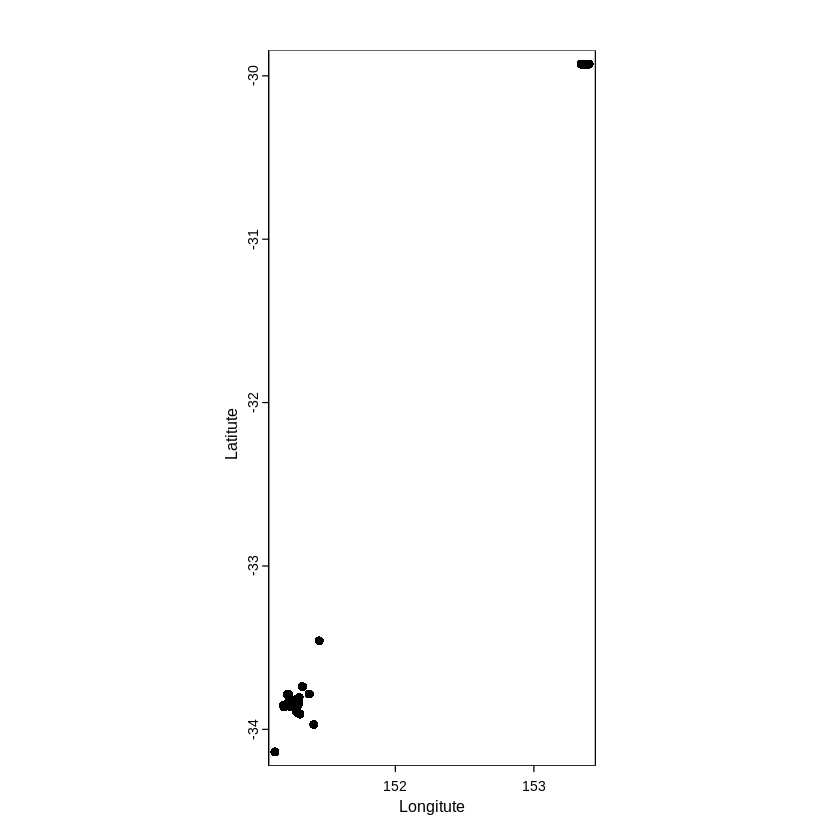

In [ ]:
# loading the data
YT <- read.csv("example_workflows_raw_data/ala_occurrences_filtered.csv", stringsAsFactors = FALSE)

dim(YT)

# Filtering the data to the desired period. Feel free to add more years and months in the code below. Don't forget to modify the accordingly in the further Code cells. 
YT <- YT |> dplyr::filter(year %in% 2012:2013 & month %in% c(1,7))

dim(YT)

# This turns the dataframe into a spatial points layer with attributes
YT_pts <- terra::vect(YT, geom=c("lon", "lat")) 

# look at your data
YT_pts
plot(YT_pts,
  xlab="Longitute", ylab="Latitute")


Now we are going to upload some bathemetry data



[1] "GEOGCRS[\"WGS 84\",\n    ENSEMBLE[\"World Geodetic System 1984 ensemble\",\n        MEMBER[\"World Geodetic System 1984 (Transit)\"],\n        MEMBER[\"World Geodetic System 1984 (G730)\"],\n        MEMBER[\"World Geodetic System 1984 (G873)\"],\n        MEMBER[\"World Geodetic System 1984 (G1150)\"],\n        MEMBER[\"World Geodetic System 1984 (G1674)\"],\n        MEMBER[\"World Geodetic System 1984 (G1762)\"],\n        MEMBER[\"World Geodetic System 1984 (G2139)\"],\n        ELLIPSOID[\"WGS 84\",6378137,298.257223563,\n            LENGTHUNIT[\"metre\",1]],\n        ENSEMBLEACCURACY[2.0]],\n    PRIMEM[\"Greenwich\",0,\n        ANGLEUNIT[\"degree\",0.0174532925199433]],\n    CS[ellipsoidal,2],\n        AXIS[\"geodetic latitude (Lat)\",north,\n            ORDER[1],\n            ANGLEUNIT[\"degree\",0.0174532925199433]],\n        AXIS[\"geodetic longitude (Lon)\",east,\n            ORDER[2],\n            ANGLEUNIT[\"degree\",0.0174532925199433]],\n    USAGE[\n        SCOPE[\"Horizontal component of 3D system.\"],\n        AREA[\"World.\"],\n        BBOX[-90,-180,90,180]],\n    ID[\"EPSG\",4326]]"

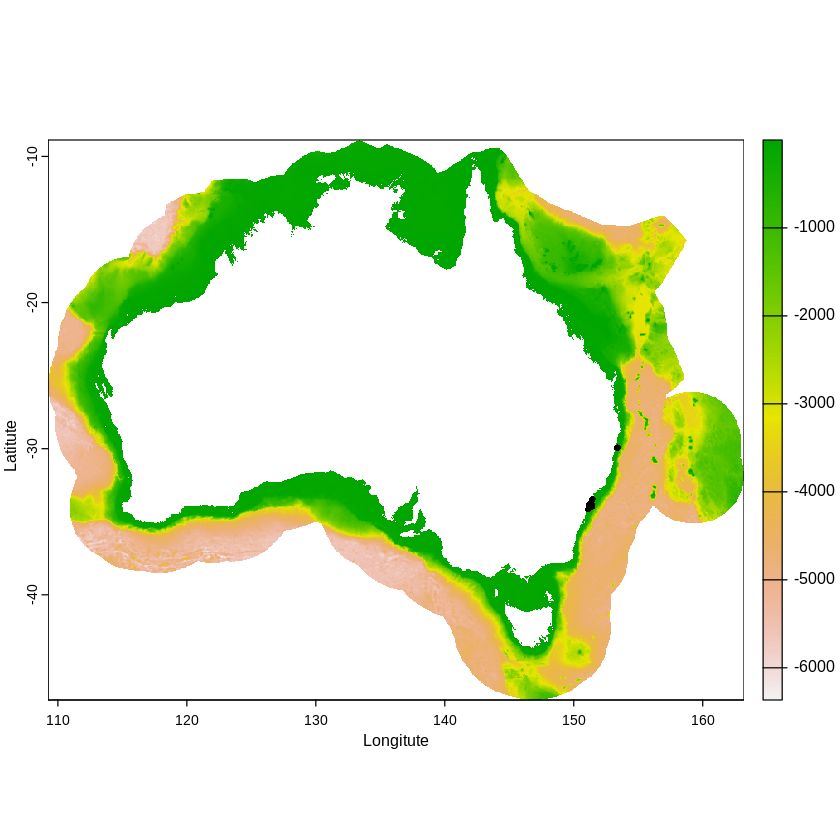

In [21]:
bath <- rast("example_workflows_raw_data/bath/bathy.tiff")
crs(bath)
plot(bath,
  xlab="Longitute", ylab="Latitute")
points(YT_pts)


Next we use a focal function on the edge of the raster to estimate bathemetry values at near-coastal areas where bathymetry data is missing by specifying arguments (na.policy="only",na.rm=T), by averaging values within 7 grid cells



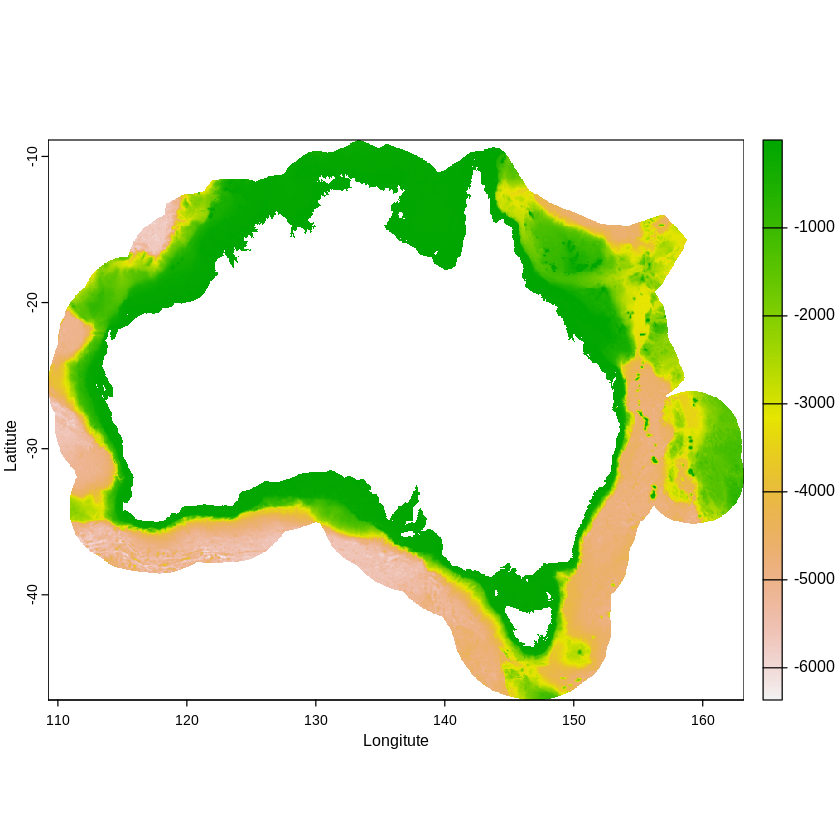

In [22]:
wt <- matrix (data = 1, nrow = 7, ncol = 7)
bath2 <- terra::focal(bath, w=wt, fun="mean", na.policy="only", na.rm=T) 
plot(bath2,
  xlab="Longitute", ylab="Latitute")


Next we verify that we now have bathemetry data at all the sensor locations, including those in shallow water



In [ ]:
YT_bath <- terra::extract(bath2,YT[,c(4,3)])
summary(YT_bath)
# then write the result as a GeoTif
dir.create("data1", showWarnings = FALSE)
writeRaster(bath2,paste0(getwd(),"/",("data1/bathemetry.tif")), overwrite=TRUE)


Note: we dropped the 'ucur' variable after initial analysis (it added little to the result). We also dropped the distance from the coast & bathymetry variables (both resulted in under-prediction far from the coast)

Below we show one example of how to generate a BIAS layer

AODN sensors are deployed at shallow areas around the Australian continent and the sensors detect any tagged fish that swims by a sensor. Environmental conditions far from the locations where sensors have been deployed are unlikely to be represented in the occurrence data.


class       : SpatRaster 
dimensions  : 4599, 6476, 1  (nrow, ncol, nlyr)
resolution  : 1, 1  (x, y)
extent      : 0, 6476, 0, 4599  (xmin, xmax, ymin, ymax)
coord. ref. :  
source(s)   : memory
name        : sum 
min value   :   1 
max value   :   1 

Warning message:
“[summary] used a sample”


      sum   
 Min.   :1  
 1st Qu.:1  
 Median :1  
 Mean   :1  
 3rd Qu.:1  
 Max.   :1  

ERROR: Error: [project] input raster CRS not set


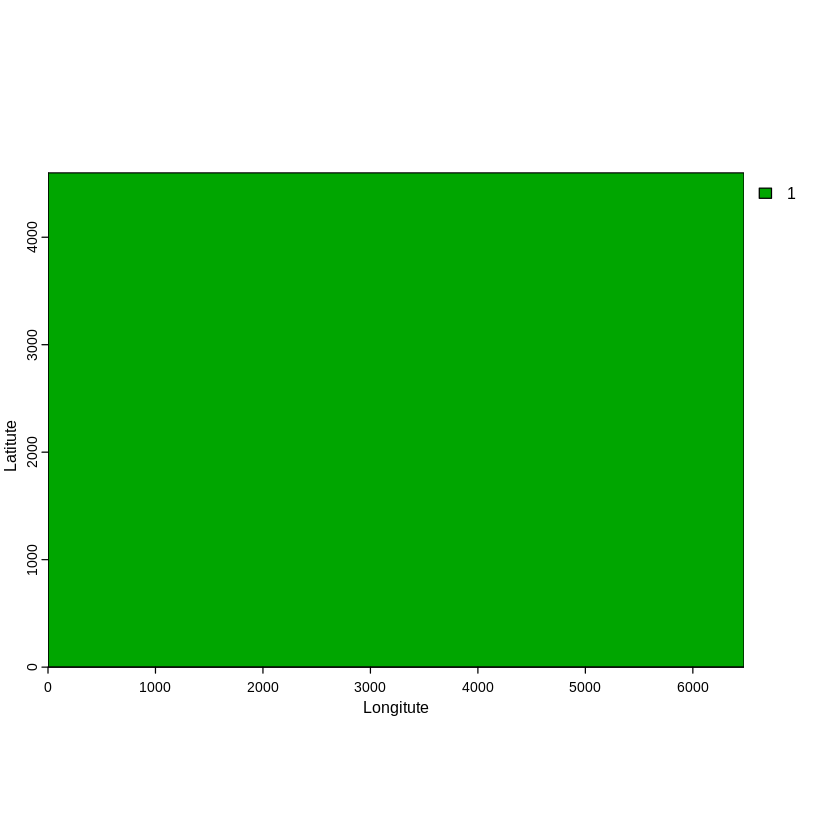

In [17]:
stations <- read.csv("example_workflows_raw_data/IMOS_array_summarised.csv")
st_xy <- cbind(stations$lon,stations$lat)
colnames(st_xy)<- c("Long","Lat")
days <- stations$days_deployed
b1 <- terra::rasterize(st_xy,bath2,days,fun=sum,background=1)
plot(b1,
  xlab="Longitute", ylab="Latitute")
b1
summary(b1)

b2 <- terra::project(b1,bath2)
plot(b2,
  xlab="Longitute", ylab="Latitute")
b3<-mask(b2,bath2)
# if there had been enough sampling in enough cells this could be the bias layer
plot(b3,
  xlab="Longitute", ylab="Latitute")
terra::ext(b3)
lg<-c(109.2333,163.2)
lt<-c(-47.2,-8.875)
coordss<-cbind(lg,lt)
st_xy2<-rbind(st_xy,coordss) # this step ensures we have coordinates
#  needed to calculate a kernel density for the entire extent


Now we use a two dimensional density kernel to capture spatial bias in sampling of environmental space (geographic distance is used as proxy of environmental space)



In [18]:
require(MASS)

dens <- kde2d(st_xy2[,1], st_xy2[,2], n = c(nrow(b2), ncol(b2)))
b4<-raster::raster(dens)
plot(b4,
  xlab="Longitute", ylab="Latitute")
b4a<-terra::rast(b4)
b5 <- terra::project(b4a,bath2)
plot(b5,
  xlab="Longitute", ylab="Latitute")

b6 <- mask(b5,bath2)
plot(b6,
  xlab="Longitute", ylab="Latitute")

dir.create("bias",showWarnings = FALSE)
writeRaster(b6,paste0(getwd(),"/",("bias/Bias_AODN.tif")), overwrite=TRUE)


ERROR: Error in kde2d(st_xy2[, 1], st_xy2[, 2], n = c(nrow(b2), ncol(b2))): object 'st_xy2' not found


Next, we will summarise the available raw data into monthly averages.

First, we need to create some directories. Note the formatting of the paste0 directory can be fiddly depending on your local environment.


In [26]:
dir.create("monthly_predictors",showWarnings = FALSE)

# We are only considering January and July. NOTE: If you added more months please add them to the code below.
sub_dirs <- c("01","07")

for(i in 1:length(sub_dirs)){
  dir.create(paste0("./monthly_predictors/",sub_dirs[i]))
}


Now, we will generate monthly data for chl or chlorophyll.



In [27]:
t1 <- list.files(path='example_workflows_raw_data/chl/', recursive=TRUE)
#get only unique charater strings near end of string in new list
t2<-unique(substr(t1,6,7))

# Averaging by month

for (i in 1:length(unique(t2))){
  txt_files=list.files(path='example_workflows_raw_data/chl/', pattern=paste("*\\-",unique(t2)[i],'.*\\.tif',sep=""),recursive=TRUE)
  stack<-terra::rast(paste0('example_workflows_raw_data/chl/', txt_files))
  filename<-"chl"
  filen<-mean(stack)
  mean_chl_1 <-project(filen,bath2)
  wt2 <- matrix (data = 1, nrow = 33, ncol = 33)
  mean_chl_2 <- focal(mean_chl_1, wt2, fun = mean, na.rm = TRUE, NAonly = TRUE)
  mean_chl_3 <- raster::mask(mean_chl_2, bath2)
  names(mean_chl_3) <- "chl"
  writeRaster(mean_chl_3,paste0("./monthly_predictors/",unique(t2)[i],"/chl.tif"),
              overwrite=TRUE)
}


Warning message:
“TIFFFillStrip:Read error at scanline 1968; got 3871 bytes, expected 37528 (GDAL error 1)”
Warning message:
“TIFFReadEncodedStrip() failed. (GDAL error 1)”
Warning message:
“/home/jovyan/migratory-modeling-notebooks/chl/2012-01.tif, band 1: IReadBlock failed at X offset 0, Y offset 1969: TIFFReadEncodedStrip() failed. (GDAL error 1)”
Warning message:
“TIFFFillStrip:Read error at scanline 2220; got 30928 bytes, expected 36754 (GDAL error 1)”
Warning message:
“TIFFReadEncodedStrip() failed. (GDAL error 1)”
Warning message:
“/home/jovyan/migratory-modeling-notebooks/chl/2013-01.tif, band 1: IReadBlock failed at X offset 0, Y offset 2221: TIFFReadEncodedStrip() failed. (GDAL error 1)”
Warning message:
“TIFFFillStrip:Read error at scanline 1968; got 0 bytes, expected 37609 (GDAL error 1)”
Warning message:
“TIFFReadEncodedStrip() failed. (GDAL error 1)”
Warning message:
“/home/jovyan/migratory-modeling-notebooks/chl/2012-01.tif, band 1: IReadBlock failed at X offset 0, Y off

ERROR: Error: [project] output crs is not valid


Next, we generate monthly summaries of the gsla variable.



In [28]:
t1 <- list.files(path='example_workflows_raw_data/gsla/', recursive=TRUE)
#get only unique charater strings near end of string in new list
t2<-unique(substr(t1,6,7))

# Averaging by month

for (i in 1:length(unique(t2))){
  txt_files=list.files(path='example_workflows_raw_data/gsla/', 
                       pattern=paste("*\\-",unique(t2)[i],'.*\\.tif',sep=""),
                       recursive=TRUE)
  stack<-terra::rast(paste0('example_workflows_raw_data/gsla/', txt_files))
  filen<-mean(stack)
  mean_gsla_1 <-project(filen,bath2)
  wt2 <- matrix (data = 1, nrow = 15, ncol = 15)
  mean_gsla_2 <- focal(mean_gsla_1, wt2, fun = mean, na.rm = TRUE, NAonly = TRUE)
  mean_gsla_3 <- raster::mask(mean_gsla_2, bath2)
  names(mean_gsla_3) <- "gsla"
  writeRaster(mean_gsla_3,paste0("./monthly_predictors/",unique(t2)[i],"/gsla.tif"),
              overwrite=TRUE)
}


ERROR: Error: [project] output crs is not valid


Then, we create monthly summaries again for sea surface temperature.



In [ ]:
t1 <- list.files(path='example_workflows_raw_data/sst/', recursive=TRUE)
#get only unique charater strings near end of string in new list
t2<-unique(substr(t1,6,7))

# Averaging by month

for (i in 1:length(unique(t2))){
  txt_files=list.files(path='example_workflows_raw_data/sst/',
                       pattern=paste("*\\-",unique(t2)[i],'.*\\.tif',sep=""),
                       recursive=TRUE)
  stack<-terra::rast(paste0('example_workflows_raw_data/sst/', txt_files))
  filen<-mean(stack)
  mean_sst_1 <-project(filen,bath2)
  wt2 <- matrix (data = 1, nrow = 35, ncol = 35)
  mean_sst_2 <- focal(mean_sst_1, wt2, fun = mean, na.rm = TRUE, NAonly = TRUE)
  mean_sst_3 <- raster::mask(mean_sst_2, bath2)
  names(mean_sst_3) <- "sst"
  writeRaster(mean_sst_3,paste0("./monthly_predictors/",unique(t2)[i],"/sst.tif"),
              overwrite=TRUE)
}


And again for the vcur variable.



In [ ]:
t1 <- list.files(path='example_workflows_raw_data/vcur/', recursive=TRUE)
#get only unique charater strings near end of string in new list
t2<-unique(substr(t1,6,7))

# Averaging by month

for (i in 1:length(unique(t2))){
  txt_files=list.files(path='example_workflows_raw_data/vcur/', 
                       pattern=paste("*\\-",unique(t2)[i],'.*\\.tif',sep=""),
                       recursive=TRUE)
  stack<-terra::rast(paste0('example_workflows_raw_data/vcur/', txt_files))
  filen<-mean(stack)
  mean_vcur_1 <-project(filen,bath2)
  wt2 <- matrix (data = 1, nrow = 15, ncol = 15)
  mean_vcur_2 <- focal(mean_vcur_1, wt2, fun = mean, na.rm = TRUE, NAonly = TRUE)
  mean_vcur_3 <- raster::mask(mean_vcur_2, bath2)
  names(mean_vcur_3) <- "vcur"
  writeRaster(mean_vcur_3,paste0("./monthly_predictors/",unique(t2)[i],"/vcur.tif"),
              overwrite=TRUE)
}


Next, we generate a unique raster for each month of the year with all grid-cell values corresponding to the numeric month value.

Then, we create a base layer where each value equals one, then create a loop to generate monthly values.


In [ ]:
base <- bath2/bath2

t1 <- list.files(path='example_workflows_raw_data/vcur/', recursive=TRUE)

#get only unique charater strings near end of string in new list
t2<-unique(substr(t1,6,7))

for (i in 1:length(t2)){
  month<- as.numeric(t2[i])
  mo<- base*month
  names(mo) <- "mo"
  writeRaster(mo,paste0("./monthly_predictors/",t2[i],"/mo.tif"),
              overwrite=TRUE)
}


# Modelling

The next steps will require some additional packages.


In [ ]:
library(dismo)
library(sf)
library(rJava)
#library(jpeg)
require(stringr)


Next we add a couple of columns to our occurrence dataset.



In [ ]:
YT$month <- sprintf("%02d", as.numeric(YT$month))
YT$mo <- as.factor(as.numeric(YT$month))
head(YT)


We then check if maxent.jar and associated files are available. Download the Maxent software to your working directory if needed.
https://biodiversityinformatics.amnh.org/open_source/maxent/ 


In [ ]:
jar <- paste(system.file(package = "dismo"), "/java/maxent.jar", sep = '') 
if (file.exists(jar)) {
  cat("Can continue, Maxent is available")
} else {
  cat("Cannot run this because Maxent is not available")
}


Now we are going to check for correlations in our variables using January data.  First we need to create a stack of January rasters.



In [ ]:
rast_lst <- list.files(path = "./monthly_predictors/01", pattern='.tif$', all.files=TRUE)
rast_lst<-rast_lst[-3]
YT_env_vars <- raster::stack(paste0("./monthly_predictors/01/",rast_lst))
crs(YT_env_vars)<-crs(bath)
YT_env_vars


Now we will check for correlations in our environmental variables, assuming January is representative of other months.



In [ ]:
panel.cor <- function(x, y, digits=2, prefix="", cex.cor, ...)
{
  usr <- par("usr"); on.exit(par(usr))
  par(usr = c(0, 1, 0, 1))
  r <- abs(cor(x, y, use="pairwise.complete.obs"))
  txt <- format(c(r, 0.123456789), digits=digits)[1]
  txt <- paste(prefix, txt, sep="")
  if(missing(cex.cor)) cex.cor <- 0.8/strwidth(txt)
  text(0.5, 0.5, txt, cex = cex.cor * r)
}
rpoints<-randomPoints(YT_env_vars,1000)
samp<-raster::extract(YT_env_vars,rpoints)
pairs(samp,lower.panel=panel.smooth,upper.panel=panel.cor)


Next do some data prep



In [ ]:
x_YTKF<- YT$lon
y_YTKF<-YT$lat
xy_YTKF<-cbind(x_YTKF,y_YTKF)
xy.sp_YTKF<-SpatialPoints(xy_YTKF)
crs(xy.sp_YTKF) <- crs(YT_env_vars)
crs(xy.sp_YTKF)

plot(YT_env_vars[[1]])
points(xy.sp_YTKF,pch=20,cex=0.2)

mask_r <- YT_env_vars[[2]]
ext <- raster::extent(YT_env_vars)


Make some more directories



In [ ]:
dir.create("data",showWarnings = FALSE)
dir.create("./data/env_dframe/",showWarnings = FALSE)


Next extract the data for each month in our dataframe from each month's environmental variables.



In [ ]:
t1<-unique(YT$month)

t1<-sort(t1)
bias <- raster("./bias/Bias_AODN.tif")

for (i in 1:length(t1)){
  subsetYT<-YT[which(YT$month==t1[i]), ]
  longitude<-subsetYT$lon
  latitude<-subsetYT$lat
  xy<-cbind(longitude,latitude)
  xy.sp<-SpatialPoints(xy)
  raster::crs(xy.sp) <- raster::crs(YT_env_vars)
  
  chl<-raster(paste0("./monthly_predictors/",unique(t2)[i],"/chl.tif"))
  
  gsla<-raster(paste0("./monthly_predictors/",unique(t2)[i],"/gsla.tif"))
  
  mo<-raster(paste0("./monthly_predictors/",unique(t2)[i],"/mo.tif"))
  
  sst<-raster(paste0("./monthly_predictors/",unique(t2)[i],"/sst.tif"))
  
  vcur<-raster(paste0("./monthly_predictors/",unique(t2)[i],"/vcur.tif"))
  
  EVstack<-raster::stack(chl,gsla,mo,sst,vcur)
  raster::crs(EVstack) <- raster::crs(YT_env_vars)
  
  presEV <- as.data.frame(raster::extract(EVstack,xy.sp))
  pres_p <- cbind(longitude,latitude,presEV)
  pres_p$pres <- 1
  
  
  rpoints<-as.data.frame(raster::xyFromCell(bias, sample(which(!is.na(values(bias))), 
                                            2000,
                                            prob=values(bias)[!is.na(values(bias))])))
  colnames(rpoints)<-c("longitude","latitude")
  xy.bk<-SpatialPoints(rpoints)
  raster::crs(xy.bk) <- raster::crs(EVstack)
  bkgEV <- as.data.frame(raster::extract(EVstack,xy.bk))
  bkg_p <- cbind(rpoints,bkgEV)
  bkg_p$pres <- 0
  
  dat1 <- rbind(pres_p,bkg_p)
  write.csv(dat1,paste0("./data/env_dframe/env_",unique(t2)[i],".csv"))
}


Next we combine all the files from the monthly data extractions



In [ ]:
files <- list.files("./data/env_dframe/")
#setwd("./data/env_dframe/")

data1 <- do.call("rbind",lapply(paste0("./data/env_dframe/",files), read.csv, header=TRUE))

data1$mo <- as.factor(data1$mo)
pa<- data1$pres

data1$pres<-NULL
data1$X<-NULL
data1$longitude<-NULL
data1$latitude<-NULL

write.csv(data1,"./data/maxent_env_dat.csv")
write.csv(pa,"./data/pa_vector.csv")


Now we create one maxent model from all the months of data combined.



In [ ]:
dir.create("Results_SmallMarine",showWarnings = FALSE)

maxent_args <- c('removeduplicates=TRUE','jackknife=TRUE',
                 'responsecurves=TRUE','plots=TRUE','betamultiplier=3')
Maxent_model1 <- dismo::maxent(x=data1,p=pa,path = "Results_SmallMarine",
                               args= maxent_args)


Plot response curves for the Maxent model.
See the Results_SmallMarine folder for more results.


In [ ]:
response(Maxent_model1)



Now lets generate some monthly predictions based on this global model



In [ ]:
for (i in 1:length(unique(t1))){
  subsetYT<-YT[which(YT$month==unique(t1)[i]), ]
  longitude<-subsetYT$lon
  latitude<-subsetYT$lat
  xy<-cbind(longitude,latitude)
  xy.sp<-SpatialPoints(xy)
  raster::crs(xy.sp) <- raster::crs(YT_env_vars)
  
  chl<-raster(paste0("./monthly_predictors/",unique(t1)[i],"/chl.tif"))
  
  gsla<-raster(paste0("./monthly_predictors/",unique(t1)[i],"/gsla.tif"))
  
  mo<-raster(paste0("./monthly_predictors/",unique(t1)[i],"/mo.tif"))
  
  sst<-raster(paste0("./monthly_predictors/",unique(t1)[i],"/sst.tif"))
  
  vcur<-raster(paste0("./monthly_predictors/",unique(t1)[i],"/vcur.tif"))
  
  Vstack<-stack(chl,gsla,mo,sst,vcur)
  raster::crs(EVstack) <- raster::crs(YT_env_vars)
  
  filenameM <- paste0("/Results_SmallMarine/map_pred_",unique(t1)[i],".tif")
  map_predictions <- predict(Maxent_model1, Vstack,filename=paste0(getwd(),filenameM), 
                      args= c('outputformat=cloglog','outputgrids=TRUE',
                    'applythresholdrule=Maximum training sensitivity plus specificity'),
                    overwrite=TRUE)

 jpeg(file= paste0(getwd(), "/Results_SmallMarine/YTKF_predicted_",unique(t1)[i],".jpeg"))
  plot(map_predictions, main=paste0("Yellowtail Kingfish distribution month =",unique(t1)[i]))
  points(xy.sp,pch=20,cex=0.2)
  dev.off()
  
  results<-read.csv(file= paste0(getwd(),"/Results_SmallMarine/maxentResults.csv"))
  
  thresh<-results$Maximum.training.sensitivity.plus.specificity.area
  m <- c(0, thresh, 0,  thresh, 1, 1)
  reclass <- matrix(m, ncol= 3, byrow= TRUE)
  rc <- reclassify(map_predictions, reclass)
  
  jpeg(paste0(getwd(),"/Results_SmallMarine/YTKF_thresholded_",unique(t1)[i],".jpeg"))
  plot(rc, main=paste0("Yellowtail Kingfish distribution month =",unique(t1)[i]))
  points(xy.sp,pch=20,cex=0.2)
  dev.off()
}


Thank you :)